In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [2]:
%load_ext autoreload
%autoreload 2
#import CCPA_lib as cp
import sorf_lib as sf

In [3]:
sns.set_context('talk')
sns.set_style('white')


![](http://oregonstate.edu/instruct/bb450/fall14/stryer7/2/table_02_02.jpg)

https://www.uniprot.org/uniprot/Q7V735

http://tigrfams.jcvi.org/cgi-bin/HmmReportPage.cgi?acc=TIGR03798

https://www.ebi.ac.uk/training/online/course/interpro-functional-and-structural-analysis-protei/sequence-searching/searching-interpro-batc

http://www.ebi.ac.uk/interpro/sequencesearch/iprscan5-S20190707-131508-0462-76111813-p1m

https://www.ebi.ac.uk/Tools/services/rest/iprscan5/result/iprscan5-S20190707-131508-0462-76111813-p1m/json

In [4]:
oorder = ['Intergenic', 'Antisense', 'Out of Frame','In Frame',  'Annotated', ]
opalette = sns.color_palette("rainbow", 5).as_hex()
#del opalette[4]
genome='MIT9313'

In [5]:
found_sorf_df = pd.read_pickle('found_sorf_ISME16.pkl.gz')

In [6]:
found_sorf_df.drop_duplicates(subset='orfid', inplace=True)

# Gene Families

In [7]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(found_sorf_df['product'].value_counts())

hypothetical protein                                                                            69
Nif11-like leader peptide family natural product precursor                                      18
                                                                                                 8
high light inducible protein                                                                     4
DUF4278 domain-containing protein                                                                2
2Fe-2S iron-sulfur cluster binding domain-containing protein                                     2
4a-hydroxytetrahydrobiopterin dehydratase                                                        2
DUF2973 domain-containing protein                                                                1
DUF3721 domain-containing protein                                                                1
50S ribosomal protein L28                                                                        1
DUF3764 fa

In [8]:
found_sorf_df['family2'] = found_sorf_df['family']
found_sorf_df.loc[found_sorf_df['product'].str.contains('ribosomal'), 'family2'] = 'ribosomal'
found_sorf_df.loc[found_sorf_df['product'].str.contains('photosystem'), 'family2'] = 'photosystem'
found_sorf_df.loc[found_sorf_df['product'].str.contains('hypothetical'), 'family2'] = 'hypothetical'
found_sorf_df.loc[found_sorf_df['product'] == '', 'family2'] = 'N/A'
found_sorf_df.loc[found_sorf_df['product'].str.contains('domain-containing protein') &
                  found_sorf_df['product'].str.startswith('DUF') , 'family2'] = 'DUF'
found_sorf_df.loc[found_sorf_df['product'].str.contains('family protein') &
                  found_sorf_df['product'].str.startswith('DUF') , 'family2'] = 'DUF'
found_sorf_df.loc[found_sorf_df['product'].str.contains('high light inducible protein'), 'family2'] = 'HLIP'
found_sorf_df.loc[found_sorf_df['product'].str.contains('carboxysome'), 'family2'] = 'carboxysome'
found_sorf_df.loc[found_sorf_df['family2'].isna(), 'family2'] = 'other'
found_sorf_df.loc[~found_sorf_df['family'].isna(), 'family2'] = found_sorf_df.loc[~found_sorf_df['family'].isna(), 'family']


In [9]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', 100000):  # more options can be specified also
    #display(found_sorf_df.loc[found_sorf_df.family2.isna(), 'product'].value_counts())    
    display(found_sorf_df.loc[found_sorf_df.family2.isna(), 'product'].sort_values().reset_index(drop=True))

Series([], Name: product, dtype: object)

In [10]:
found_sorf_df.groupby(['family2'])['product'].value_counts()

family2    product                          
CCRG-2     CCRG-2 family RiPP                   1
           hypothetical protein                 1
DUF        DUF4278 domain-containing protein    2
           DUF1816 domain-containing protein    1
           DUF1995 family protein               1
                                               ..
ribosomal  50S ribosomal protein L28            1
           50S ribosomal protein L29            1
           50S ribosomal protein L31            1
           50S ribosomal protein L32            1
           50S ribosomal protein L33            1
Name: product, Length: 67, dtype: int64

In [11]:
found_sorf_df.loc[found_sorf_df['family2'] == 'other']['product'].value_counts()

4a-hydroxytetrahydrobiopterin dehydratase                                                       2
2Fe-2S iron-sulfur cluster binding domain-containing protein                                    2
response regulator transcription factor                                                         1
glutaredoxin 3                                                                                  1
rubredoxin                                                                                      1
BolA family transcriptional regulator                                                           1
ATP-dependent Clp protease adapter ClpS                                                         1
CopG family transcriptional regulator                                                           1
chlororespiratory reduction protein 7                                                           1
YlxR family protein                                                                             1
translation initiati

# BLAST vs SORFS

In [12]:
def is_in_found_sorf(r):
    orfid = r.id.replace('lcl|','')
    return found_sorf_df.orfid.isin([orfid]).sum() > 0
    

In [13]:
accession = sf.get_accession(genome)
orf_dpath = 'orffinder_tmp'
orf_fpath = os.path.join(orf_dpath, f'{accession}.orffinder.fa')

In [14]:
from Bio import SeqIO
records = (r for r in SeqIO.parse(orf_fpath, "fasta") if is_in_found_sorf(r))

In [15]:
out_fpath = os.path.join(orf_dpath, f'{genome}_found_proteome.fasta')
count = SeqIO.write(records, out_fpath, "fasta")
print("Saved %i records from %s to %s" % (count, orf_fpath, out_fpath))

Saved 164 records from orffinder_tmp\BX548175.orffinder.fa to orffinder_tmp\MIT9313_found_proteome.fasta


 mit9313_found_vs_pro_syn    https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Get&RID=8P2ACMPV014    
 mit9313_found_vs_nr         https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Get&RID=8P26YCM7014
 mit9313_found_vs_swisprot   https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Get&RID=8SHSH1FU014
 

In [16]:
blast_dpath = os.path.join('orffinder_tmp','blast results')
blast_vs_nr_dpath = os.path.join(blast_dpath, 'mit9313_found_vs_nr-Alignment.xml')
blast_vs_pro_dpath = os.path.join(blast_dpath, 'mit9313_found_vs_pro_syn-Alignment.xml')
blastn_vs_pro_dpath = os.path.join(blast_dpath, 'mit9313_blastn_vs_pro_syn-Alignment.xml')

blast_vs_sorf_dpath = os.path.join(blast_dpath, 'mit9313_sorf_all_vs_all.xml')
blast_vs_swisprot_dpath = os.path.join(blast_dpath, 'mit9313_found_vs_swisprot-Alignment.xml')

os.listdir(blast_dpath)

['BHXV0U5D014-Alignment.xml',
 'mit9313_blastn_vs_pro_syn-Alignment.xml',
 'mit9313_blastn_vs_pro_syn-Alignment1.xml',
 'mit9313_found_vs_pro_syn-Alignment.xml',
 'mit9313_found_vs_swisprot-Alignment.xml',
 'mit9313_sorf_all_vs_all.xml',
 'old']

In [17]:
from Bio.Blast import NCBIXML


# BLAST vs SORF

In [18]:
def blast_rec_to_dict(blast_rec):
    query_id = blast_rec.query.replace(' unnamed protein product','').replace('lcl|','')
    results = [{
        'query' : query_id,
        'aligment_id' : alignment.hit_def.split()[0].replace('lcl|', ''), 
        'alignment_def' : alignment.hit_def,
        'coverage': np.round(np.mean([hsp.align_length / blast_rec.query_length for hsp in alignment.hsps]), decimals=2),
        'identity': np.round(np.mean([hsp.identities / blast_rec.query_length for hsp in alignment.hsps]), decimals=2),
        
        }
        for alignment in blast_rec.alignments if alignment.hit_id != query_id
    ]
    return results

In [19]:
fh = open(blast_vs_sorf_dpath)
blast_records = NCBIXML.parse(fh)
reslist = [blast_rec_to_dict(b) for b in blast_records]
blast_vs_sorf_df = pd.DataFrame([i for lst in reslist for i in lst])

In [20]:
fh.close()

In [21]:
for query in blast_records:
    for alignment in query.alignments:
        for hsp in alignment.hsps:
            print('coverage', hsp.align_length / query.query_length)
            print('identitiy', hsp.identities/ hsp.align_length)

In [22]:
blast_vs_sorf_df.head()

,query,aligment_id,alignment_def,coverage,identity
0,ORF533_BX548175.1:237054:237281,ORF533_BX548175.1:237054:237281,lcl|ORF533_BX548175.1:237054:237281 unnamed pr...,1.00,1.00
1,ORF2049_BX548175.1:913137:913382,ORF2049_BX548175.1:913137:913382,lcl|ORF2049_BX548175.1:913137:913382 unnamed p...,1.00,1.00
2,ORF2049_BX548175.1:913137:913382,ORF26372_BX548175.1:2236618:2236379,lcl|ORF26372_BX548175.1:2236618:2236379 unname...,0.93,0.75
3,ORF2049_BX548175.1:913137:913382,ORF26370_BX548175.1:2237020:2236769,lcl|ORF26370_BX548175.1:2237020:2236769 unname...,0.79,0.72
4,ORF2049_BX548175.1:913137:913382,ORF20045_BX548175.1:274995:274750,lcl|ORF20045_BX548175.1:274995:274750 unnamed ...,0.84,0.69


In [23]:
def create_sorfs_cluster(blast_vs_sorf_df, cluster_sorfs):
    new_alignments = set(
        blast_vs_sorf_df.loc[blast_vs_sorf_df['query'].isin(cluster_sorfs), 'aligment_id'].unique()
    )
    new_queries = set(
        blast_vs_sorf_df.loc[blast_vs_sorf_df['aligment_id'].isin(cluster_sorfs), 'query'].unique()
    )
    if (new_alignments <= cluster_sorfs) and (new_queries <= cluster_sorfs):
        return cluster_sorfs
    else:
        new_cluster_sorfs = cluster_sorfs | new_alignments | new_queries
        return create_sorfs_cluster(blast_vs_sorf_df, new_cluster_sorfs)
    
    

In [24]:
def create_sorfs_cluster_sel_root(blast_vs_sorf_df, visited):
    not_visited = blast_vs_sorf_df.loc[~blast_vs_sorf_df['query'].isin(visited), 'query'].unique()
    if len(not_visited):
        return create_sorfs_cluster(blast_vs_sorf_df, {not_visited[0]})
    #else
    not_visited2 = blast_vs_sorf_df.loc[~blast_vs_sorf_df['aligment_id'].isin(visited), 'aligment_id'].unique()
    if len(not_visited2):
        return create_sorfs_cluster(blast_vs_sorf_df, {not_visited2[0]})
    # else
    return None
    


In [25]:
visited = set()
clusters = []
while(True):
    new_cluster = create_sorfs_cluster_sel_root(blast_vs_sorf_df, visited)
    if new_cluster is None:
        break
    visited = visited | new_cluster
    clusters.append(new_cluster)
    

In [26]:
len(clusters)

139

In [27]:
clusters

[{'ORF533_BX548175.1:237054:237281'},
 {'ORF15620_BX548175.1:2243295:2243047',
  'ORF15637_BX548175.1:2235903:2235652',
  'ORF15638_BX548175.1:2235486:2235229',
  'ORF15639_BX548175.1:2235150:2234896',
  'ORF20045_BX548175.1:274995:274750',
  'ORF20053_BX548175.1:273630:273355',
  'ORF2049_BX548175.1:913137:913382',
  'ORF20960_BX548175.1:2244944:2244663',
  'ORF20982_BX548175.1:2236277:2236026',
  'ORF25351_BX548175.1:278051:277779',
  'ORF25353_BX548175.1:276446:276159',
  'ORF25368_BX548175.1:272714:272418',
  'ORF25455_BX548175.1:233492:233262',
  'ORF26352_BX548175.1:2244112:2243855',
  'ORF26353_BX548175.1:2243725:2243456',
  'ORF26370_BX548175.1:2237020:2236769',
  'ORF26372_BX548175.1:2236618:2236379',
  'ORF5422_BX548175.1:182116:182298',
  'ORF7032_BX548175.1:905452:905715'},
 {'ORF2068_BX548175.1:922530:922661'},
 {'ORF2106_BX548175.1:940263:940514'},
 {'ORF2222_BX548175.1:986481:986612'},
 {'ORF18490_BX548175.1:968157:967891', 'ORF2321_BX548175.1:1030986:1031147'},
 {'ORF23

In [28]:
real_clusters = [i for i in clusters if len(i)>1]
for i,c in enumerate(real_clusters, start=1):
    found_sorf_df.loc[found_sorf_df.orfid.isin(c), 'cluster_id'] = i

In [29]:
len(real_clusters)

11

In [30]:
found_sorf_df.head()

,orfid,contig,left,right,start,stop,strand,aaseq,len_nn,len_aa,...,AAs,MW [kDa],calc. pI,tempaccession,max_xCorr,multiple unique peptides,has unique peptides,ms_detected,family2,cluster_id
578,ORF533_BX548175.1:237054:237281,BX548175.1,237054,237281,237054,237281,+,MLYLVAPAGDGRDVYATLYAQRMFFLVTLQPRGAQFEVIPYQDARH...,228,75,...,75,8.89242,6.771,unnamed protein product - [ORF533_BX548175.1:2...,4.305928,True,True,True,other,NaN
2286,ORF2049_BX548175.1:913137:913382,BX548175.1,913137,913382,913137,913382,+,MSEEQLKAFIAKVQGDTSLQEQLKAEGADVVAIAKAAGFSITTEDL...,246,81,...,81,8.50516,4.48779,unnamed protein product - [ORF2049_BX548175.1:...,5.280437,True,True,True,ProcA,1.0
2317,ORF2068_BX548175.1:922530:922661,BX548175.1,922530,922661,922530,922661,+,MMGKTKQHKKLVSWAEKAELCATREEAQKLIRKAEKAHAKLES,132,43,...,43,4.93366,9.71533,unnamed protein product - [ORF2068_BX548175.1:...,3.770810,False,True,True,N/A,NaN
2647,ORF2321_BX548175.1:1030986:1031147,BX548175.1,1030986,1031147,1030986,1031147,+,MLSKSITGMFGRRNKKDAPKEEPTETDLERGYRLAAAKQKEILKEL...,162,53,...,53,6.04028,9.89111,unnamed protein product - [ORF2321_BX548175.1:...,5.131342,True,True,True,N/A,2.0
2652,ORF2325_BX548175.1:1032375:1032665,BX548175.1,1032375,1032665,1032375,1032665,+,MLFLFDMTFLMHWSFKTGYHEKAARQFLATGAPMPECKSWQRFHAP...,291,96,...,96,10.9832,5.07178,unnamed protein product - [ORF2325_BX548175.1:...,3.434773,False,True,True,DUF,NaN


In [31]:
found_sorf_df.groupby(['cluster_id','family2'])['product'].value_counts()

cluster_id  family2       product                                                   
1.0         ProcA         Nif11-like leader peptide family natural product precursor    18
                          lantipeptide                                                   1
2.0         N/A                                                                          1
            hypothetical  hypothetical protein                                           1
3.0         HLIP          high light inducible protein                                   2
4.0         hypothetical  hypothetical protein                                           2
5.0         hypothetical  hypothetical protein                                           2
6.0         hypothetical  hypothetical protein                                           2
7.0         hypothetical  hypothetical protein                                           2
8.0         hypothetical  hypothetical protein                                           1
     

In [32]:
found_sorf_df.groupby(['cluster_id', 'otype', 'orfid', 'product', #'family'
                      ])['family'].unique().str.join(',').reset_index()

,cluster_id,otype,orfid,product,family
0,1.0,Annotated,ORF15620_BX548175.1:2243295:2243047,Nif11-like leader peptide family natural produ...,ProcA
1,1.0,Annotated,ORF15637_BX548175.1:2235903:2235652,Nif11-like leader peptide family natural produ...,ProcA
2,1.0,Annotated,ORF15638_BX548175.1:2235486:2235229,lantipeptide,ProcA
3,1.0,Annotated,ORF15639_BX548175.1:2235150:2234896,Nif11-like leader peptide family natural produ...,ProcA
4,1.0,Annotated,ORF20045_BX548175.1:274995:274750,Nif11-like leader peptide family natural produ...,ProcA
5,1.0,Annotated,ORF20053_BX548175.1:273630:273355,Nif11-like leader peptide family natural produ...,ProcA
6,1.0,Annotated,ORF2049_BX548175.1:913137:913382,Nif11-like leader peptide family natural produ...,ProcA
7,1.0,Annotated,ORF20960_BX548175.1:2244944:2244663,Nif11-like leader peptide family natural produ...,ProcA
8,1.0,Annotated,ORF20982_BX548175.1:2236277:2236026,Nif11-like leader peptide family natural produ...,ProcA
9,1.0,Annotated,ORF25353_BX548175.1:276446:276159,Nif11-like leader peptide family natural produ...,ProcA


In [33]:
found_sorf_df.loc[found_sorf_df.cluster_id.isna()]['otype'].value_counts()

Annotated     99
In Frame      15
Intergenic     7
Antisense      2
Name: otype, dtype: int64

In [34]:
found_sorf_df.pivot_table(columns='otype', index='family2',aggfunc='count', values='orfid').sum()


otype
Annotated       131.0
Antisense         2.0
In Frame         22.0
Intergenic        8.0
Out of Frame      1.0
dtype: float64

In [35]:
found_sorf_df.otype.value_counts()

Annotated       131
In Frame         22
Intergenic        8
Antisense         2
Out of Frame      1
Name: otype, dtype: int64

# tBLASTn vs PRO /SYN genomes

In [36]:
def pro_blastn_to_description(blast_rec):
    query_id = blast_rec.query.replace(' unnamed protein product','').replace('lcl|','')
    results = [{
        'query' : query_id,
        'pro_syn' : a.hit_def,
        'pro_syn_accession' : d.accession,
        'pro_syn_hsps' : len(a.hsps),
        'pro_syn_coverage': np.round(np.mean([hsp.align_length / blast_rec.query_length for hsp in a.hsps]), decimals=2),
        'pro_syn_identity': np.round(np.mean([hsp.identities / blast_rec.query_length for hsp in a.hsps]), decimals=2),
        }
        for d,a in zip(blast_rec.descriptions, blast_rec.alignments)
    ]
    return results

In [37]:
fh = open(blastn_vs_pro_dpath)
blast_records = NCBIXML.parse(fh)
reslist = [pro_blastn_to_description(b) for b in blast_records]
blastn_vs_pro_df = pd.DataFrame([i for lst in reslist for i in lst])

In [38]:
fh.close()

In [39]:
blastn_vs_pro_df.head()

,query,pro_syn,pro_syn_accession,pro_syn_hsps,pro_syn_coverage,pro_syn_identity
0,ORF533_BX548175.1:237054:237281,"Prochlorococcus marinus str. MIT 9303, complet...",CP000554,1,1.0,1.00
1,ORF533_BX548175.1:237054:237281,Prochlorococcus marinus MIT9313 complete genome,BX548175,1,1.0,1.00
2,ORF533_BX548175.1:237054:237281,"Synechococcus sp. KORDI-49, complete genome",CP006270,1,1.0,0.83
3,ORF533_BX548175.1:237054:237281,"Synechococcus sp. WH 8109, complete genome",CP006882,1,1.0,0.83
4,ORF533_BX548175.1:237054:237281,"Synechococcus sp. KORDI-52, complete genome",CP006271,1,1.0,0.81


In [40]:
grouped_blastn_vs_pro_df =  blastn_vs_pro_df.loc[
    ~blastn_vs_pro_df.pro_syn.str.contains('MIT9313')
    ].groupby(by='query').agg({'pro_syn': 'count', 'pro_syn_hsps': 'mean'}).reset_index()
grouped_blastn_vs_pro_df.rename(columns={
    'pro_syn': 'pro/syn genomes', 
    'pro_syn_hsps': 'mean pro/syn alignments', 
    'pro_syn_coverage': 'mean pro/syn coverage',
    'pro_syn_identity': 'mean pro/syn identity'},
                                inplace=True)

In [41]:
grouped_blastn_vs_9313_df =  blastn_vs_pro_df.loc[
    blastn_vs_pro_df.pro_syn.str.contains('MIT9313')
    ].groupby(by='query').agg({'pro_syn': 'count', 'pro_syn_hsps': 'mean'}).reset_index()
grouped_blastn_vs_9313_df.rename(columns={
    'pro_syn': 'mit9313', 
    'pro_syn_hsps': 'mit9313 alignments',
    'pro_syn_coverage': 'mean mit9313 coverage',
    'pro_syn_identity': 'mean mit9313 identity'},
                                inplace=True)

In [42]:
found_sorf_df = pd.merge(found_sorf_df, 
         grouped_blastn_vs_pro_df,
         left_on='orfid', right_on='query', how='left')

In [43]:
found_sorf_df = pd.merge(found_sorf_df, 
         grouped_blastn_vs_9313_df,
         left_on='orfid', right_on='query', how='left')

In [44]:
found_sorf_df.head()

,orfid,contig,left,right,start,stop,strand,aaseq,len_nn,len_aa,...,has unique peptides,ms_detected,family2,cluster_id,query_x,pro/syn genomes,mean pro/syn alignments,query_y,mit9313,mit9313 alignments
0,ORF533_BX548175.1:237054:237281,BX548175.1,237054,237281,237054,237281,+,MLYLVAPAGDGRDVYATLYAQRMFFLVTLQPRGAQFEVIPYQDARH...,228,75,...,True,True,other,NaN,ORF533_BX548175.1:237054:237281,53.0,1.018868,ORF533_BX548175.1:237054:237281,1.0,1.0
1,ORF2049_BX548175.1:913137:913382,BX548175.1,913137,913382,913137,913382,+,MSEEQLKAFIAKVQGDTSLQEQLKAEGADVVAIAKAAGFSITTEDL...,246,81,...,True,True,ProcA,1.0,ORF2049_BX548175.1:913137:913382,5.0,12.000000,ORF2049_BX548175.1:913137:913382,1.0,34.0
2,ORF2068_BX548175.1:922530:922661,BX548175.1,922530,922661,922530,922661,+,MMGKTKQHKKLVSWAEKAELCATREEAQKLIRKAEKAHAKLES,132,43,...,True,True,N/A,NaN,ORF2068_BX548175.1:922530:922661,11.0,1.000000,ORF2068_BX548175.1:922530:922661,1.0,1.0
3,ORF2321_BX548175.1:1030986:1031147,BX548175.1,1030986,1031147,1030986,1031147,+,MLSKSITGMFGRRNKKDAPKEEPTETDLERGYRLAAAKQKEILKEL...,162,53,...,True,True,N/A,2.0,ORF2321_BX548175.1:1030986:1031147,1.0,3.000000,ORF2321_BX548175.1:1030986:1031147,1.0,3.0
4,ORF2325_BX548175.1:1032375:1032665,BX548175.1,1032375,1032665,1032375,1032665,+,MLFLFDMTFLMHWSFKTGYHEKAARQFLATGAPMPECKSWQRFHAP...,291,96,...,True,True,DUF,NaN,ORF2325_BX548175.1:1032375:1032665,15.0,1.000000,ORF2325_BX548175.1:1032375:1032665,1.0,1.0


# blast vs pro syn

In [45]:
def prosyn_blast_to_description(blast_rec):
    query_id = blast_rec.query.replace(' unnamed protein product','').replace('lcl|','')
    results = [{
        'query' : query_id,
        'pro_syn_description' : d.title.split('=', maxsplit=1)[-1],
        'pro_syn_accession': d.accession,
        'pro_syn_e' : d.e,
        'pro_syn_coverage': np.round(np.mean([hsp.align_length / blast_rec.query_length for hsp in a.hsps]), decimals=2),
        'pro_syn_identity': np.round(np.mean([hsp.identities / blast_rec.query_length for hsp in a.hsps]), decimals=2),
        
        }
        for d,a in zip(blast_rec.descriptions, blast_rec.alignments)
    ]
    return results

In [46]:
fh = open(blast_vs_pro_dpath)
blast_records = NCBIXML.parse(fh)
reslist = [prosyn_blast_to_description(b) for b in blast_records]
blast_vs_pro_df = pd.DataFrame([i for lst in reslist for i in lst])

In [47]:
blast_vs_pro_df.loc[blast_vs_pro_df.pro_syn_description.str.contains('9313')].head()

,query,pro_syn_description,pro_syn_accession,pro_syn_e,pro_syn_coverage,pro_syn_identity
3,ORF533_BX548175.1:237054:237281,ref|WP_011129584.1| MULTISPECIES: PipX family ...,WP_011129584,2.020000e-51,1.00,1.00
100,ORF2049_BX548175.1:913137:913382,ref|WP_011130214.1| Nif11-like leader peptide ...,WP_011130214,4.276760e-53,1.00,1.00
101,ORF2049_BX548175.1:913137:913382,ref|WP_011130304.1| Nif11-like leader peptide ...,WP_011130304,2.422000e-36,0.98,0.80
103,ORF2049_BX548175.1:913137:913382,ref|WP_011131487.1| Nif11-like leader peptide ...,WP_011131487,1.567570e-35,0.93,0.75
106,ORF2049_BX548175.1:913137:913382,ref|WP_011131488.1| Nif11-like leader peptide ...,WP_011131488,2.785820e-35,0.79,0.72


In [48]:
found_sorf_df = pd.merge(found_sorf_df, 
         blast_vs_pro_df.loc[blast_vs_pro_df.groupby('query').pro_syn_e.idxmin()].reset_index(drop=True),
         left_on='orfid', right_on='query', how='left')

In [49]:
found_sorf_df.head()

,orfid,contig,left,right,start,stop,strand,aaseq,len_nn,len_aa,...,mean pro/syn alignments,query_y,mit9313,mit9313 alignments,query,pro_syn_description,pro_syn_accession,pro_syn_e,pro_syn_coverage,pro_syn_identity
0,ORF533_BX548175.1:237054:237281,BX548175.1,237054,237281,237054,237281,+,MLYLVAPAGDGRDVYATLYAQRMFFLVTLQPRGAQFEVIPYQDARH...,228,75,...,1.018868,ORF533_BX548175.1:237054:237281,1.0,1.0,ORF533_BX548175.1:237054:237281,gb|KZR77542.1| hypothetical protein PMIT1323_0...,KZR77542,1.367810e-51,1.0,1.00
1,ORF2049_BX548175.1:913137:913382,BX548175.1,913137,913382,913137,913382,+,MSEEQLKAFIAKVQGDTSLQEQLKAEGADVVAIAKAAGFSITTEDL...,246,81,...,12.000000,ORF2049_BX548175.1:913137:913382,1.0,34.0,ORF2049_BX548175.1:913137:913382,ref|WP_011130214.1| Nif11-like leader peptide ...,WP_011130214,4.276760e-53,1.0,1.00
2,ORF2068_BX548175.1:922530:922661,BX548175.1,922530,922661,922530,922661,+,MMGKTKQHKKLVSWAEKAELCATREEAQKLIRKAEKAHAKLES,132,43,...,1.000000,ORF2068_BX548175.1:922530:922661,1.0,1.0,ORF2068_BX548175.1:922530:922661,gb|ABM78103.1| Hypothetical protein P9303_1356...,ABM78103,1.409580e-20,1.0,0.93
3,ORF2321_BX548175.1:1030986:1031147,BX548175.1,1030986,1031147,1030986,1031147,+,MLSKSITGMFGRRNKKDAPKEEPTETDLERGYRLAAAKQKEILKEL...,162,53,...,3.000000,ORF2321_BX548175.1:1030986:1031147,1.0,3.0,ORF2321_BX548175.1:1030986:1031147,gb|KZR65522.1| hypothetical protein PMIT1306_0...,KZR65522,4.962770e-32,1.0,1.00
4,ORF2325_BX548175.1:1032375:1032665,BX548175.1,1032375,1032665,1032375,1032665,+,MLFLFDMTFLMHWSFKTGYHEKAARQFLATGAPMPECKSWQRFHAP...,291,96,...,1.000000,ORF2325_BX548175.1:1032375:1032665,1.0,1.0,ORF2325_BX548175.1:1032375:1032665,gb|KZR64481.1| hypothetical protein PMIT1303_0...,KZR64481,3.384840e-69,1.0,1.00


# blast vs swisprot

In [50]:
def swisprot_blast_to_description(blast_rec):
    query_id = blast_rec.query.replace(' unnamed protein product','').replace('lcl|','')
    results = [{
        'query' : query_id,
        'swis_description' : d.title.split('=', maxsplit=1)[-1],
        'swis_e' : d.e,
        'swis_coverage': np.round(np.mean([hsp.align_length / blast_rec.query_length for hsp in a.hsps]), decimals=2),
        'swis_identity': np.round(np.mean([hsp.identities / blast_rec.query_length for hsp in a.hsps]), decimals=2),
        
        }
        for d,a in zip(blast_rec.descriptions, blast_rec.alignments)
    ]
    return results

In [51]:
fh = open(blast_vs_swisprot_dpath)
blast_records = NCBIXML.parse(fh)
reslist = [swisprot_blast_to_description(b) for b in blast_records]
blast_vs_swis_df = pd.DataFrame([i for lst in reslist for i in lst])

In [52]:
found_sorf_df = pd.merge(found_sorf_df, 
         blast_vs_swis_df.loc[blast_vs_swis_df.groupby('query').swis_e.idxmin()].reset_index(drop=True),
         left_on='orfid', right_on='query', how='left')

In [53]:
found_sorf_df.otype.value_counts()

Annotated       131
In Frame         22
Intergenic        8
Antisense         2
Out of Frame      1
Name: otype, dtype: int64

In [54]:
found_sorf_df.dropna(subset=['swis_description']).otype.value_counts()

Annotated    35
In Frame      4
Name: otype, dtype: int64

In [55]:
found_sorf_df.shape

(164, 95)

# Analysis

In [56]:
[(i,len(j)) for i,j in enumerate(real_clusters, start=1)]

[(1, 19),
 (2, 2),
 (3, 2),
 (4, 2),
 (5, 2),
 (6, 2),
 (7, 2),
 (8, 2),
 (9, 2),
 (10, 3),
 (11, 3)]

In [57]:
found_sorf_df.groupby(['cluster_id','family2'])['product'].value_counts()

cluster_id  family2       product                                                   
1.0         ProcA         Nif11-like leader peptide family natural product precursor    18
                          lantipeptide                                                   1
2.0         N/A                                                                          1
            hypothetical  hypothetical protein                                           1
3.0         HLIP          high light inducible protein                                   2
4.0         hypothetical  hypothetical protein                                           2
5.0         hypothetical  hypothetical protein                                           2
6.0         hypothetical  hypothetical protein                                           2
7.0         hypothetical  hypothetical protein                                           2
8.0         hypothetical  hypothetical protein                                           1
     

In [58]:
found_sorf_df.loc[found_sorf_df.cluster_id.isna() & ~found_sorf_df.family2.isin(['other'])].groupby(['family2'])['product'].value_counts()

family2       product                                      
DUF           DUF4278 domain-containing protein                 2
              DUF1816 domain-containing protein                 1
              DUF1995 family protein                            1
              DUF2470 domain-containing protein                 1
              DUF2555 domain-containing protein                 1
              DUF2862 domain-containing protein                 1
              DUF2949 domain-containing protein                 1
              DUF2973 domain-containing protein                 1
              DUF3136 domain-containing protein                 1
              DUF3148 domain-containing protein                 1
              DUF3181 family protein                            1
              DUF3252 domain-containing protein                 1
              DUF3303 family protein                            1
              DUF3721 domain-containing protein                 1
              DU

In [59]:
found_sorf_df.loc[found_sorf_df.cluster_id.isna() & found_sorf_df.family2.isin(['other'])]['product'].value_counts()

4a-hydroxytetrahydrobiopterin dehydratase                                                       2
2Fe-2S iron-sulfur cluster binding domain-containing protein                                    2
NAD(P)H-quinone oxidoreductase subunit O                                                        1
guanylate-binding protein                                                                       1
YciI family protein                                                                             1
cupin domain-containing protein                                                                 1
rubredoxin                                                                                      1
NifU family protein                                                                             1
BolA family transcriptional regulator                                                           1
ATP-dependent Clp protease adapter ClpS                                                         1
CopG family transcri

In [60]:
found_sorf_df.loc[found_sorf_df.family2.isin(['other']), 'product'].value_counts()

4a-hydroxytetrahydrobiopterin dehydratase                                                       2
2Fe-2S iron-sulfur cluster binding domain-containing protein                                    2
response regulator transcription factor                                                         1
glutaredoxin 3                                                                                  1
rubredoxin                                                                                      1
BolA family transcriptional regulator                                                           1
ATP-dependent Clp protease adapter ClpS                                                         1
CopG family transcriptional regulator                                                           1
chlororespiratory reduction protein 7                                                           1
YlxR family protein                                                                             1
translation initiati

In [61]:
pd.set_option('display.max_colwidth', -1)
found_sorf_df.groupby(['cluster_id', 'otype', 'orfid', 'product', #'swis_description', #'family'
                      ])['family2'].unique().str.join(',').reset_index()

,cluster_id,otype,orfid,product,family2
0,1.0,Annotated,ORF15620_BX548175.1:2243295:2243047,Nif11-like leader peptide family natural product precursor,ProcA
1,1.0,Annotated,ORF15637_BX548175.1:2235903:2235652,Nif11-like leader peptide family natural product precursor,ProcA
2,1.0,Annotated,ORF15638_BX548175.1:2235486:2235229,lantipeptide,ProcA
3,1.0,Annotated,ORF15639_BX548175.1:2235150:2234896,Nif11-like leader peptide family natural product precursor,ProcA
4,1.0,Annotated,ORF20045_BX548175.1:274995:274750,Nif11-like leader peptide family natural product precursor,ProcA
5,1.0,Annotated,ORF20053_BX548175.1:273630:273355,Nif11-like leader peptide family natural product precursor,ProcA
6,1.0,Annotated,ORF2049_BX548175.1:913137:913382,Nif11-like leader peptide family natural product precursor,ProcA
7,1.0,Annotated,ORF20960_BX548175.1:2244944:2244663,Nif11-like leader peptide family natural product precursor,ProcA
8,1.0,Annotated,ORF20982_BX548175.1:2236277:2236026,Nif11-like leader peptide family natural product precursor,ProcA
9,1.0,Annotated,ORF25353_BX548175.1:276446:276159,Nif11-like leader peptide family natural product precursor,ProcA


In [62]:
found_sorf_df.loc[found_sorf_df.cluster_id.isna()]['otype'].value_counts()

Annotated     99
In Frame      15
Intergenic    7 
Antisense     2 
Name: otype, dtype: int64

In [63]:
found_sorf_df.pivot_table(columns='otype', index='family2',aggfunc='count', values='orfid', margins=True).reset_index()

otype,family2,Annotated,Antisense,In Frame,Intergenic,Out of Frame,All
0,CCRG-2,2.0,NaN,NaN,NaN,NaN,2
1,DUF,12.0,NaN,4.0,NaN,NaN,16
2,HLIP,3.0,NaN,1.0,NaN,NaN,4
3,N/A,NaN,NaN,NaN,8.0,NaN,8
4,ProcA,16.0,NaN,2.0,NaN,1.0,19
5,carboxysome,2.0,NaN,NaN,NaN,NaN,2
6,hypothetical,57.0,2.0,9.0,NaN,NaN,68
7,other,23.0,NaN,5.0,NaN,NaN,28
8,photosystem,5.0,NaN,1.0,NaN,NaN,6
9,ribosomal,11.0,NaN,NaN,NaN,NaN,11


In [64]:
found_sorf_df.otype.value_counts()

Annotated       131
In Frame        22 
Intergenic      8  
Antisense       2  
Out of Frame    1  
Name: otype, dtype: int64

In [65]:
found_sorf_df.columns

Index(['orfid', 'contig', 'left', 'right', 'start', 'stop', 'strand', 'aaseq',
       'len_nn', 'len_aa', 'len_aa3', 'rast_left', 'rast_right', 'contig_id',
       'gene_id', 'location', 'type', 'start_r', 'stop_r', 'function',
       'figfam', 'nucleotide_sequence', 'aa_sequence', 'genome', 'left_r',
       'right_r', 'overlap_location', 'overlap_strand', 'overlap_gene_type',
       'overlap_count', 'is_same_strand', 'is_out_of_frame', 'is_inside',
       'is_upstream', 'is_downstream', 'overlap_type', 'otype',
       'merge_location', 'contig_id_overlap', 'gene_id_overlap', 'pmt_id',
       'type_overlap', 'location_overlap', 'strand_overlap', 'start_overlap',
       'stop_overlap', 'left_overlap', 'right_overlap', 'function_overlap',
       'genome_overlap', 'old_locus_tag', 'product', 'db_xref', 'protein_id',
       'figfam_overlap', 'nucleotide_sequence_overlap', 'aa_sequence_overlap',
       'family', 'Gene', 'Accession', 'Description', 'Score', 'Coverage',
       'Proteins', 'Un

In [66]:
pd.set_eng_float_format()

In [67]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.precision', 0)
found_sorf_df.dropna(subset=['swis_description'])[['family2','otype', 'pro/syn genomes',
       'mean pro/syn alignments', 'product', 'swis_description', 'swis_e',
       'swis_coverage', 'swis_identity' ]]

,family2,otype,pro/syn genomes,mean pro/syn alignments,product,swis_description,swis_e,swis_coverage,swis_identity
6,other,In Frame,49.000E+00,1.000E+00,FADH(2)-oxidizing methylenetetrahydrofolate--tRNA-(uracil(54)-C(5))- methyltransferase TrmFO,Methylenetetrahydrofolate--tRNA-(uracil-5-)-methyltransferase TrmFO; AltName: Full=Folate-dependent tRNA (uracil-5-)-methyltransferase; AltName: Full=Folate-dependent tRNA(M-5-U54)-methyltransferase [Prochlorococcus marinus str. MIT 9303],0.000E-24,1.000E+00,950.000E-03
7,other,Annotated,51.000E+00,1.000E+00,BolA family transcriptional regulator,Uncharacterized protein ssr3122 [Synechocystis sp. PCC 6803 substr. Kazusa],0.000E-24,1.000E+00,640.000E-03
10,HLIP,In Frame,54.000E+00,1.833E+00,high light inducible protein,Uncharacterized protein ycf17; AltName: Full=ORF48 [Cyanophora paradoxa],502.447E-09,620.000E-03,300.000E-03
16,ribosomal,Annotated,86.000E+00,1.000E+00,30S ribosomal protein S19,30S ribosomal protein S19 [Prochlorococcus marinus str. MIT 9303] >sp|Q7TUP5.1| RecName: Full=30S ribosomal protein S19 [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00
17,ribosomal,Annotated,56.000E+00,1.000E+00,50S ribosomal protein L29,50S ribosomal protein L29 [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00
21,other,Annotated,52.000E+00,2.519E+00,response regulator transcription factor,Oxygen regulatory protein NreC; AltName: Full=Nitrogen regulation protein C [Staphylococcus aureus RF122] >sp|Q6GE42.1| RecName: Full=Oxygen regulatory protein NreC; AltName: Full=Nitrogen regulation protein C [Staphylococcus aureus subsp. aureus MRSA252],126.809E-12,610.000E-03,280.000E-03
33,ribosomal,Annotated,83.000E+00,1.000E+00,30S ribosomal protein S15,30S ribosomal protein S15 [Prochlorococcus marinus str. MIT 9303] >sp|Q7TV07.1| RecName: Full=30S ribosomal protein S15 [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00
34,ribosomal,Annotated,80.000E+00,1.000E+00,30S ribosomal protein S18,30S ribosomal protein S18 [Prochlorococcus marinus str. MIT 9303] >sp|Q7TUZ8.1| RecName: Full=30S ribosomal protein S18 [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00
35,ribosomal,Annotated,78.000E+00,1.000E+00,50S ribosomal protein L32,50S ribosomal protein L32 [Prochlorococcus marinus str. MIT 9303] >sp|Q7V7I8.1| RecName: Full=50S ribosomal protein L32 [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00
44,other,Annotated,50.000E+00,1.100E+00,4a-hydroxytetrahydrobiopterin dehydratase,Putative pterin-4-alpha-carbinolamine dehydratase; Short=PHS; AltName: Full=4-alpha-hydroxy-tetrahydropterin dehydratase; AltName: Full=Pterin carbinolamine dehydratase; Short=PCD [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00


In [68]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.precision', 0)
found_sorf_df.dropna(subset=['swis_description']).loc[found_sorf_df.otype == 'Out of Frame',
      ['family2','otype', 'pro/syn genomes',
       'mean pro/syn alignments', 'product', 'swis_description', 'swis_e',
       'swis_coverage', 'swis_identity',
 'pro_syn_accession', 
                   'pro_syn_description','pro_syn_e', 'pro_syn_coverage',
       'pro_syn_identity', 'aa_sequence_overlap', 'aaseq'
      ]]

,family2,otype,pro/syn genomes,mean pro/syn alignments,product,swis_description,swis_e,swis_coverage,swis_identity,pro_syn_accession,pro_syn_description,pro_syn_e,pro_syn_coverage,pro_syn_identity,aa_sequence_overlap,aaseq


In [69]:
found_sorf_df.columns

Index(['orfid', 'contig', 'left', 'right', 'start', 'stop', 'strand', 'aaseq',
       'len_nn', 'len_aa', 'len_aa3', 'rast_left', 'rast_right', 'contig_id',
       'gene_id', 'location', 'type', 'start_r', 'stop_r', 'function',
       'figfam', 'nucleotide_sequence', 'aa_sequence', 'genome', 'left_r',
       'right_r', 'overlap_location', 'overlap_strand', 'overlap_gene_type',
       'overlap_count', 'is_same_strand', 'is_out_of_frame', 'is_inside',
       'is_upstream', 'is_downstream', 'overlap_type', 'otype',
       'merge_location', 'contig_id_overlap', 'gene_id_overlap', 'pmt_id',
       'type_overlap', 'location_overlap', 'strand_overlap', 'start_overlap',
       'stop_overlap', 'left_overlap', 'right_overlap', 'function_overlap',
       'genome_overlap', 'old_locus_tag', 'product', 'db_xref', 'protein_id',
       'figfam_overlap', 'nucleotide_sequence_overlap', 'aa_sequence_overlap',
       'family', 'Gene', 'Accession', 'Description', 'Score', 'Coverage',
       'Proteins', 'Un

In [70]:
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.precision', 0)
found_sorf_df.loc[found_sorf_df.otype.isin(['Intergenic', 'Antisense', 'Out of Frame']),
                  ['otype', 'orfid', #'mit9313 alignments','pro/syn genomes',
                   'strand', 
                  ]]

,otype,orfid,strand
2,Intergenic,ORF2068_BX548175.1:922530:922661,+
3,Intergenic,ORF2321_BX548175.1:1030986:1031147,+
36,Out of Frame,ORF7032_BX548175.1:905452:905715,+
42,Intergenic,ORF7466_BX548175.1:1097200:1097379,+
65,Antisense,ORF12508_BX548175.1:1082192:1082350,+
85,Intergenic,ORF16879_BX548175.1:1658121:1657948,-
95,Intergenic,ORF18609_BX548175.1:926268:926035,-
98,Antisense,ORF18932_BX548175.1:798918:798733,-
103,Intergenic,ORF19962_BX548175.1:317208:317134,-
117,Intergenic,ORF22713_BX548175.1:1476551:1476351,-


In [71]:
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.precision', 0)
found_sorf_df.loc[found_sorf_df.otype.isin(['Out of Frame']),
                  ['orfid', #'mit9313 alignments','pro/syn genomes',
                   #'mean pro/syn alignments', 'pro_syn_accession', 
                   #'pro_syn_description','pro_syn_e', 'pro_syn_coverage',
       #'pro_syn_identity', 'cluster_id'
                   'function', 'product',
                   'strand',
                   'aaseq',
                   'gene_id_overlap','protein_id', 'overlap_location',
                   'aa_sequence_overlap',
                   'aa_sequence'
                  ]].T

# 905453..905716

,36
orfid,ORF7032_BX548175.1:905452:905715
function,None
product,Nif11-like leader peptide family natural product precursor
strand,+
aaseq,MSEEQLKAFIAKVQADASLQEQLRTEGADVVAIAKAAGFSITTEDLNSHRQNLSDDELEGVAGGGGKMTVRGRDMSCGCQDYWEDDY
gene_id_overlap,AKG35_RS04305
protein_id,
overlap_location,AKG35_RS04305
aa_sequence_overlap,
aa_sequence,None


In [72]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.precision', 0)
found_sorf_df.loc[found_sorf_df.otype.isin(['Intergenic']) & 
                  found_sorf_df.pro_syn_description.str.contains('9313'),
                  ['orfid', 'mit9313 alignments', 'strand', #'pro/syn genomes',
                   #'mean pro/syn alignments', 
                   'pro_syn_accession', 
                   'pro_syn_description','pro_syn_e', 'pro_syn_coverage',
       'pro_syn_identity', 'cluster_id']]

,orfid,mit9313 alignments,strand,pro_syn_accession,pro_syn_description,pro_syn_e,pro_syn_coverage,pro_syn_identity,cluster_id
3,ORF2321_BX548175.1:1030986:1031147,3.000E+00,+,KZR65522,gb|KZR65522.1| hypothetical protein PMIT1306_00434 [Prochlorococcus sp. MIT 1306] >gb|KZR65553.1| hypothetical protein PMIT1306_00465 [Prochlorococcus sp. MIT 1306] >emb|CAX32059.1| Hypothetical protein PMT_2540 [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00,2.000E+00
42,ORF7466_BX548175.1:1097200:1097379,1.000E+00,+,WP_011825714,ref|WP_011825714.1| unnamed protein product >gb|ABM77811.1| Conserved hypothetical protein [Prochlorococcus marinus str. MIT 9303] >gb|KZR66472.1| hypothetical protein PMIT1312_00937 [Prochlorococcus marinus str. MIT 1312] >gb|KZR70656.1| hypothetical protein PMIT1313_00310 [Prochlorococcus marinus str. MIT 1313] >gb|KZR73164.1| hypothetical protein PMIT1318_00497 [Prochlorococcus marinus str. MIT 1318] >gb|KZR77608.1| hypothetical protein PMIT1320_00378 [Prochlorococcus marinus str. MIT 1320] >gb|KZR78221.1| hypothetical protein PMIT1323_00392 [Prochlorococcus marinus str. MIT 1323] >gb|KZR82936.1| hypothetical protein PMIT1342_00587 [Prochlorococcus marinus str. MIT 1342] >gb|KZR83410.1| hypothetical protein PMIT1327_00492 [Prochlorococcus marinus str. MIT 1327] >emb|CAX32100.1| Conserved hypothetical protein [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00,NaN
85,ORF16879_BX548175.1:1658121:1657948,1.000E+00,-,CAX32265,emb|CAX32265.1| Conserved hypothetical protein [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00,NaN
103,ORF19962_BX548175.1:317208:317134,1.000E+00,-,CAE20454,emb|CAE20454.1| hypothetical [Prochlorococcus marinus str. MIT 9313],194.242E-12,1.000E+00,1.000E+00,NaN
117,ORF22713_BX548175.1:1476551:1476351,1.000E+00,-,CAX32212,emb|CAX32212.1| Conserved hypothetical protein [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00,NaN
163,ORF30974_BX548175.1:185020:184811,1.000E+00,-,CAX31811,emb|CAX31811.1| Conserved hypothetical protein [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00,NaN


In [73]:
1031011 - 1030986, 1031148- 1031147




(25, 1)

In [74]:
found_sorf_df.orfid.value_counts()

ORF8493_BX548175.1:1618480:1618644     1
ORF7288_BX548175.1:1022485:1022760     1
ORF21958_BX548175.1:1798223:1797957    1
ORF11349_BX548175.1:562598:562816      1
ORF21363_BX548175.1:2060999:2060784    1
                                      ..
ORF21341_BX548175.1:2072060:2071788    1
ORF8405_BX548175.1:1576669:1576824     1
ORF10855_BX548175.1:349523:349801      1
ORF18711_BX548175.1:886344:886132      1
ORF15637_BX548175.1:2235903:2235652    1
Name: orfid, Length: 164, dtype: int64

In [75]:
found_sorf_df.head()

,orfid,contig,left,right,start,stop,strand,aaseq,len_nn,len_aa,...,pro_syn_description,pro_syn_accession,pro_syn_e,pro_syn_coverage,pro_syn_identity,query_y,swis_description,swis_e,swis_coverage,swis_identity
0,ORF533_BX548175.1:237054:237281,BX548175.1,237054,237281,237054,237281,+,MLYLVAPAGDGRDVYATLYAQRMFFLVTLQPRGAQFEVIPYQDARHYAELHLTHCRRDRSPEYESWQQLFAQTFI,228,75,...,gb|KZR77542.1| hypothetical protein PMIT1323_00917 [Prochlorococcus marinus str. MIT 1323],KZR77542,0.000E-24,1.000E+00,1.000E+00,NaN,NaN,NaN,NaN,NaN
1,ORF2049_BX548175.1:913137:913382,BX548175.1,913137,913382,913137,913382,+,MSEEQLKAFIAKVQGDTSLQEQLKAEGADVVAIAKAAGFSITTEDLNTHRQTLSDRELEGVAGGTTAFTGVDTESIAFCCS,246,81,...,ref|WP_011130214.1| Nif11-like leader peptide family natural product precursor [Prochlorococcus marinus] >emb|CAE21011.1| hypothetical [Prochlorococcus marinus str. MIT 9313],WP_011130214,0.000E-24,1.000E+00,1.000E+00,NaN,NaN,NaN,NaN,NaN
2,ORF2068_BX548175.1:922530:922661,BX548175.1,922530,922661,922530,922661,+,MMGKTKQHKKLVSWAEKAELCATREEAQKLIRKAEKAHAKLES,132,43,...,gb|ABM78103.1| Hypothetical protein P9303_13561 [Prochlorococcus marinus str. MIT 9303],ABM78103,14.096E-21,1.000E+00,930.000E-03,NaN,NaN,NaN,NaN,NaN
3,ORF2321_BX548175.1:1030986:1031147,BX548175.1,1030986,1031147,1030986,1031147,+,MLSKSITGMFGRRNKKDAPKEEPTETDLERGYRLAAAKQKEILKELLAQKPRA,162,53,...,gb|KZR65522.1| hypothetical protein PMIT1306_00434 [Prochlorococcus sp. MIT 1306] >gb|KZR65553.1| hypothetical protein PMIT1306_00465 [Prochlorococcus sp. MIT 1306] >emb|CAX32059.1| Hypothetical protein PMT_2540 [Prochlorococcus marinus str. MIT 9313],KZR65522,0.000E-24,1.000E+00,1.000E+00,NaN,NaN,NaN,NaN,NaN
4,ORF2325_BX548175.1:1032375:1032665,BX548175.1,1032375,1032665,1032375,1032665,+,MLFLFDMTFLMHWSFKTGYHEKAARQFLATGAPMPECKSWQRFHAPGSVQGWIIVETNDAGVCYEHAAEWAEFLDWDVTPVFTDDQAGPLIAKVYS,291,96,...,gb|KZR64481.1| hypothetical protein PMIT1303_01526 [Prochlorococcus sp. MIT 1303] >gb|KZR78461.1| hypothetical protein PMIT1320_00057 [Prochlorococcus marinus str. MIT 1320] >gb|KZR78628.1| hypothetical protein PMIT1323_00054 [Prochlorococcus marinus str. MIT 1323] >emb|CAE21126.1| conserved hypothetical protein [Prochlorococcus marinus str. MIT 9313],KZR64481,0.000E-24,1.000E+00,1.000E+00,NaN,NaN,NaN,NaN,NaN


In [76]:
blastn_vs_pro_df.loc[blastn_vs_pro_df['query'].str.contains('ORF2321_BX548175.1:1030986:1031147')]

,query,pro_syn,pro_syn_accession,pro_syn_hsps,pro_syn_coverage,pro_syn_identity
72,ORF2321_BX548175.1:1030986:1031147,Prochlorococcus marinus MIT9313 complete genome,BX548175,3,1.030E+00,840.000E-03
73,ORF2321_BX548175.1:1030986:1031147,"Prochlorococcus marinus str. MIT 9303, complete genome",CP000554,3,980.000E-03,770.000E-03


In [77]:
found_sorf_df.nlargest(10, ['pro/syn genomes'])

,orfid,contig,left,right,start,stop,strand,aaseq,len_nn,len_aa,...,pro_syn_description,pro_syn_accession,pro_syn_e,pro_syn_coverage,pro_syn_identity,query_y,swis_description,swis_e,swis_coverage,swis_identity
16,ORF3964_BX548175.1:1838136:1838411,BX548175.1,1838136,1838411,1838136,1838411,+,MGRSLKKGPFIADSLLRKLEKQNADDDKSVIKTWSRASTILPMMIGHTIAVHNGRSHVPVFITEQMVGHKLGEFAPTRTFKGHIKDKKGGR,276,91,...,30S ribosomal protein S19 [Prochlorococcus marinus str. MIT 9303] >sp|Q7TUP5.1| RecName: Full=30S ribosomal protein S19 [Prochlorococcus marinus str. MIT 9313] >gb|KZR63621.1| 30S ribosomal protein S19 [Prochlorococcus marinus str. MIT 1312] >gb|KZR68347.1| 30S ribosomal protein S19 [Prochlorococcus marinus str. MIT 1313] >gb|KZR71415.1| 30S ribosomal protein S19 [Prochlorococcus marinus str. MIT 1318] >gb|KZR73938.1| 30S ribosomal protein S19 [Prochlorococcus marinus str. MIT 1320] >gb|KZR74175.1| 30S ribosomal protein S19 [Prochlorococcus marinus str. MIT 1323] >gb|KZR78775.1| 30S ribosomal protein S19 [Prochlorococcus marinus str. MIT 1327] >gb|KZR80591.1| 30S ribosomal protein S19 [Prochlorococcus marinus str. MIT 1342] >gb|NMO84452.1| 30S ribosomal protein S19 [Cyanobacteria bacterium 150SLHB] >gb|NMP06240.1| 30S ribosomal protein S19 [Cyanobacteria bacterium 150NLHA] >gb|NMP14123.1| 30S ribosomal protein S19 [Cyanobacteria bacterium 150SLHA] >gb|RPG02798.1| 30S ribosomal protein S19 [Prochlorococcus sp. TMED223] >gb|RZO51959.1| 30S ribosomal protein S19 [Prochlorococcus sp. MED-G132],WP_011131103,0.000E-24,1.000E+00,1.000E+00,ORF3964_BX548175.1:1838136:1838411,30S ribosomal protein S19 [Prochlorococcus marinus str. MIT 9303] >sp|Q7TUP5.1| RecName: Full=30S ribosomal protein S19 [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00
69,ORF13351_BX548175.1:1509413:1509679,BX548175.1,1509413,1509679,1509413,1509679,+,MAHKKGTGSTRNGRDSNSKRLGVKAYGGETVTAGSILIRQRGTSVLPGVNVGQGKDDTLFALTDGVVAFESIRRSLRNRKRISVVASS,267,88,...,50S ribosomal protein L27 [Prochlorococcus marinus str. MIT 9313] >emb|CAE21596.1| 50S ribosomal protein L27 [Prochlorococcus marinus str. MIT 9313],WP_011130789,0.000E-24,1.000E+00,1.000E+00,ORF13351_BX548175.1:1509413:1509679,50S ribosomal protein L27 [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00
75,ORF14108_BX548175.1:1840259:1840525,BX548175.1,1840259,1840525,1840259,1840525,+,MALKERLGTVVSDKMDKTVVVAVENRFPHPIYQKTVSRTTRYKAHDAGNTCRVGDRVRITETRPLSRSKRWTVAEVLSHSPKAQEVST,267,88,...,30S ribosomal protein S17 [Prochlorococcus marinus str. MIT 9313] >gb|KZR68352.1| 30S ribosomal protein S17 [Prochlorococcus marinus str. MIT 1313] >gb|KZR71410.1| 30S ribosomal protein S17 [Prochlorococcus marinus str. MIT 1318] >gb|KZR73933.1| 30S ribosomal protein S17 [Prochlorococcus marinus str. MIT 1320] >gb|KZR74180.1| 30S ribosomal protein S17 [Prochlorococcus marinus str. MIT 1323] >gb|KZR80586.1| 30S ribosomal protein S17 [Prochlorococcus marinus str. MIT 1342],WP_011131108,0.000E-24,1.000E+00,1.000E+00,ORF14108_BX548175.1:1840259:1840525,30S ribosomal protein S17 [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00
76,ORF14128_BX548175.1:1850909:1851190,BX548175.1,1850909,1851190,1850909,1851190,+,MPKPDIHPNWYPDAKVICNGEVVMTTGSTQPELHVDVWSGNHPFFTGTQKILDTEGRVDRFMRKYGMGSADAAADEKKPDAKNNNKDNTSKED,282,93,...,50S ribosomal protein L31 [Prochlorococcus marinus str. MIT 9313] >gb|KZR73915.1| 50S ribosomal protein L31 [Prochlorococcus marinus str. MIT 1320] >gb|KZR74198.1| 50S ribosomal protein L31 [Prochlorococcus marinus str. MIT 1323] >gb|RZO49287.1| 50S ribosomal protein L31 [Prochlorococcus sp. MED-G132] >emb|CAE21935.1| 50S ribosomal protein L31 [Prochlorococcus marinus str. MIT 9313],WP_011131127,0.000E-24,1.000E+00,1.000E+00,ORF14128_BX548175.1:1850909:1851190,50S ribosomal protein L31 [Prochlorococcus marinus str. MIT 9313],0.000E-24,1.000E+00,1.000E+00
33,ORF6596_BX548175.1:698671:698940,BX548175.1,698671,698940,698671,698940,+,MSLDTTEKQQLINANQTHGTDTGSVEVQVAMLSERITKLSSHLQENKHDFSSRQGLLKMI

In [78]:
found_sorf_df.nsmallest(10, ['pro/syn genomes'])

,orfid,contig,left,right,start,stop,strand,aaseq,len_nn,len_aa,...,pro_syn_description,pro_syn_accession,pro_syn_e,pro_syn_coverage,pro_syn_identity,query_y,swis_description,swis_e,swis_coverage,swis_identity
3,ORF2321_BX548175.1:1030986:1031147,BX548175.1,1030986,1031147,1030986,1031147,+,MLSKSITGMFGRRNKKDAPKEEPTETDLERGYRLAAAKQKEILKELLAQKPRA,162,53,...,gb|KZR65522.1| hypothetical protein PMIT1306_00434 [Prochlorococcus sp. MIT 1306] >gb|KZR65553.1| hypothetical protein PMIT1306_00465 [Prochlorococcus sp. MIT 1306] >emb|CAX32059.1| Hypothetical protein PMT_2540 [Prochlorococcus marinus str. MIT 9313],KZR65522,0.000E-24,1.000E+00,1.000E+00,NaN,NaN,NaN,NaN,NaN
5,ORF2340_BX548175.1:1038120:1038374,BX548175.1,1038120,1038374,1038120,1038374,+,MYSLFDSVFDVPFGYSIPRDRVVVIPDSQYNKLRAQENERQVAKLEARKEHHSQVIERLNEQISELQAALPAAEPDKELAATKE,255,84,...,ref|WP_011130332.1| guanylate-binding protein [Prochlorococcus marinus] >gb|KZR68145.1| hypothetical protein PMIT1313_02580 [Prochlorococcus marinus str. MIT 1313] >gb|KZR78307.1| hypothetical protein PMIT1318_00023 [Prochlorococcus marinus str. MIT 1318] >emb|CAE21131.1| possible Kinesin motor domain [Prochlorococcus marinus str. MIT 9313] >emb|CAE21134.1| possible Kinesin motor domain [Prochlorococcus marinus str. MIT 9313] >emb|CAE21137.1| possible Kinesin motor domain [Prochlorococcus marinus str. MIT 9313],WP_011130332,0.000E-24,1.000E+00,1.000E+00,NaN,NaN,NaN,NaN,NaN
11,ORF3835_BX548175.1:1762950:1763246,BX548175.1,1762950,1763246,1762950,1763246,+,MRFIEFLDQRFCNSQEIREINHRGISAGFDGFREVWELDYLYEHFEADIHEIIEETGYLDSDLKDEFDNEETLRMKLVWFAVSTYCLSRTDALVEAKD,297,98,...,ref|WP_011131024.1| hypothetical protein [Prochlorococcus marinus] >gb|KZR66653.1| hypothetical protein PMIT1312_00777 [Prochlorococcus marinus str. MIT 1312] >gb|KZR83230.1| hypothetical protein PMIT1327_00617 [Prochlorococcus marinus str. MIT 1327] >gb|NMO84108.1| hypothetical protein [Cyanobacteria bacterium 150SLHB] >gb|NMP05838.1| hypothetical protein [Cyanobacteria bacterium 150NLHA] >gb|NMP12617.1| hypothetical protein [Cyanobacteria bacterium 150SLHA] >emb|CAE21832.1| hypothetical [Prochlorococcus marinus str. MIT 9313],WP_011131024,0.000E-24,1.000E+00,1.000E+00,NaN,NaN,NaN,NaN,NaN
22,ORF4637_BX548175.1:2186205:2186360,BX548175.1,2186205,2186360,2186205,2186360,+,MSSSEKELDLRIDHLQKELALAEQERDILRAAKMQQKILMKLLKENPSRQV,156,51,...,ref|WP_155728142.1| MULTISPECIES: hypothetical protein [Prochlorococcus] >gb|KZR61380.1| hypothetical protein PMIT1306_02161 [Prochlorococcus sp. MIT 1306] >gb|KZR73565.1| hypothetical protein PMIT1320_02159 [Prochlorococcus marinus str. MIT 1320] >emb|CAX32398.1| Conserved hypothetical protein [Prochlorococcus marinus str. MIT 9313],WP_155728142,0.000E-24,1.000E+00,1.000E+00,NaN,NaN,NaN,NaN,NaN
28,ORF5755_BX548175.1:320164:320430,BX548175.1,320164,320430,320164,320430,+,MIMEDPESNASSSNDQTEAFEPPKNRFGIPYLLATDKEEKDMPKKEVLNVLGLQLSAPAGMQNPLLIFFGLIGVNIAIIGYFTYMLNK,267,88,...,ref|WP_063403417.1| unnamed protein product >gb|KZR70057.1| hypothetical protein PMIT1313_00703 [Prochlorococcus marinus str. MIT 1313] >gb|KZR72781.1| hypothetical protein PMIT1318_00743 [Prochlorococcus marinus str. MIT 1318] >gb|KZR82404.1| hypothetical protein PMIT1342_00874 [Prochlorococcus marinus str. MIT 1342],WP_063403417,0.000E-24,1.000E+00,990.000E-03,NaN,NaN,NaN,NaN,NaN
37,ORF7084_BX548175.1:929743:929898,BX548175.1,929743,929898,929743,929898,+,MRQSFAGTTGAVQPLATPRIQSIREKISIQELELRLTRLGLATTTHTPNPS,156,51,...,ref|WP_155724952.1| MULTISPECIES: hypothetical protein [Prochlorococcus] >gb|KZR64439.1| hypothetical protein PMIT1303_01484 [Prochlorococcus sp. MIT 1303] >gb|KZR75913.1| hypothetical protein PMIT1320_00907 [Prochlorococcus marinus str. MIT 1320] >emb|CAX31970.1| Hypothetical protein PMT_2452 [Prochlorococcus marinus str. MIT 9313],WP_155724952,0.000E-24,1.000E+00,1.000E+00,NaN,NaN,NaN,NaN,NaN
38,ORF7163_BX548175.1:972145:972303,BX548175.1,972145,972303,972145,972303,+,MPSVKPRVGWIIDPELLSLLKELADKSGRTVPKEAEQAIKNWLQLHGNLPQD,159,52,...

In [79]:
found_sorf_df.protein_id

0      WP_011129584.1
1      WP_011130214.1
2                    
3                    
4      WP_041385049.1
            ...      
159    WP_011129739.1
160    WP_041384274.1
161    WP_011129633.1
162    WP_041384252.1
163                  
Name: protein_id, Length: 164, dtype: object

In [80]:
#sns.clustermap()
blastn_vs_pro_df.head()

,query,pro_syn,pro_syn_accession,pro_syn_hsps,pro_syn_coverage,pro_syn_identity
0,ORF533_BX548175.1:237054:237281,"Prochlorococcus marinus str. MIT 9303, complete genome",CP000554,1,1.000E+00,1.000E+00
1,ORF533_BX548175.1:237054:237281,Prochlorococcus marinus MIT9313 complete genome,BX548175,1,1.000E+00,1.000E+00
2,ORF533_BX548175.1:237054:237281,"Synechococcus sp. KORDI-49, complete genome",CP006270,1,1.000E+00,830.000E-03
3,ORF533_BX548175.1:237054:237281,"Synechococcus sp. WH 8109, complete genome",CP006882,1,1.000E+00,830.000E-03
4,ORF533_BX548175.1:237054:237281,"Synechococcus sp. KORDI-52, complete genome",CP006271,1,1.000E+00,810.000E-03


In [81]:
found_sorf_df.columns

Index(['orfid', 'contig', 'left', 'right', 'start', 'stop', 'strand', 'aaseq',
       'len_nn', 'len_aa', 'len_aa3', 'rast_left', 'rast_right', 'contig_id',
       'gene_id', 'location', 'type', 'start_r', 'stop_r', 'function',
       'figfam', 'nucleotide_sequence', 'aa_sequence', 'genome', 'left_r',
       'right_r', 'overlap_location', 'overlap_strand', 'overlap_gene_type',
       'overlap_count', 'is_same_strand', 'is_out_of_frame', 'is_inside',
       'is_upstream', 'is_downstream', 'overlap_type', 'otype',
       'merge_location', 'contig_id_overlap', 'gene_id_overlap', 'pmt_id',
       'type_overlap', 'location_overlap', 'strand_overlap', 'start_overlap',
       'stop_overlap', 'left_overlap', 'right_overlap', 'function_overlap',
       'genome_overlap', 'old_locus_tag', 'product', 'db_xref', 'protein_id',
       'figfam_overlap', 'nucleotide_sequence_overlap', 'aa_sequence_overlap',
       'family', 'Gene', 'Accession', 'Description', 'Score', 'Coverage',
       'Proteins', 'Un

In [84]:
found_sorf_df['label'] = found_sorf_df['family2']
found_sorf_df.loc[
    found_sorf_df.otype.isin(['Antisense', 'Out of Frame', 'Intergenic']), 
    'label'
] = found_sorf_df.loc[
    found_sorf_df.otype.isin(['Antisense', 'Out of Frame', 'Intergenic']), 'otype'] 
row_col = found_sorf_df.groupby(['orfid'])['label'].first()
row_col

col_pal = sns.color_palette('Set2', len(row_col.unique()))

#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
col_pal = dict(zip(row_col.unique(), col_pal))


In [85]:
found_sorf_df.loc[found_sorf_df.orfid.isin(['ORF11218_BX548175.1:504881:505174', 'ORF2106_BX548175.1:940263:940514',
       'ORF2222_BX548175.1:986481:986612',
       'ORF3227_BX548175.1:1465035:1465151',
       'ORF6895_BX548175.1:838849:839127',
       'ORF8922_BX548175.1:1846900:1847043'])]

,orfid,contig,left,right,start,stop,strand,aaseq,len_nn,len_aa,...,pro_syn_accession,pro_syn_e,pro_syn_coverage,pro_syn_identity,query_y,swis_description,swis_e,swis_coverage,swis_identity,label


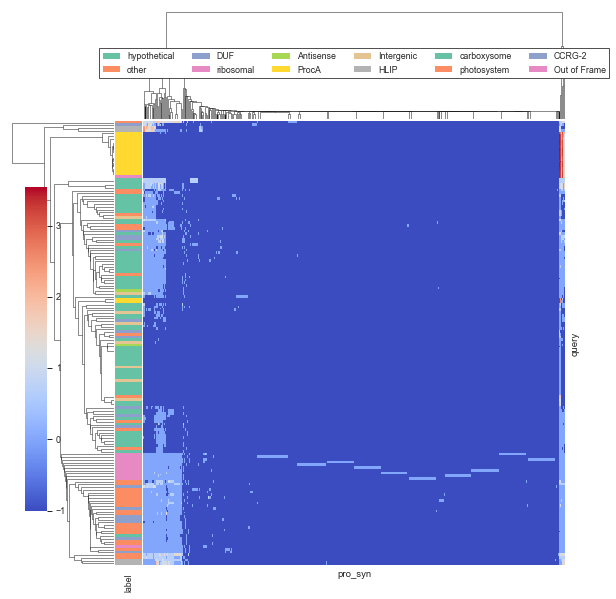

In [100]:
sns.set_context('paper')
blastn_vs_pro_df['log_hsps'] = np.log(blastn_vs_pro_df['pro_syn_hsps'])
pivotdf = blastn_vs_pro_df.loc[
    blastn_vs_pro_df['query'].isin(found_sorf_df['orfid'])
].pivot_table(columns=['pro_syn'], index='query', values=['log_hsps'],
                                      fill_value=-1, 
                                      ).droplevel(0,axis=1)
row_colors = row_col[pivotdf.index].map(col_pal)

g = sns.clustermap(data=pivotdf, cmap='coolwarm', row_colors=row_colors,
                  linewidths=0, xticklabels=False, yticklabels=False)



for label in row_col.unique():
    g.ax_col_dendrogram.bar(0, 0, color=col_pal[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=6)
g.cax.set_position([.15, .2, .03, .45])


In [92]:
pivotdf.shape

(163, 475)

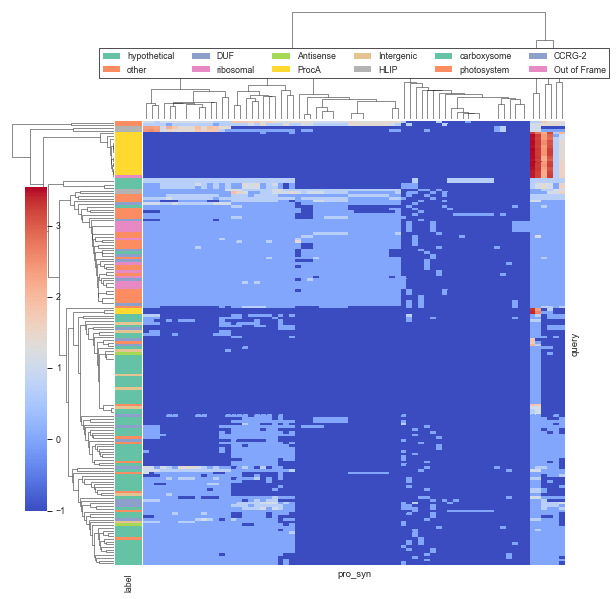

In [105]:
g = sns.clustermap(data=pivotdf.loc[:, (pivotdf >= 0).sum()>3], 
                   cmap='coolwarm', row_colors=row_colors,
                  linewidths=0, xticklabels=False, yticklabels=False, #standard_scale=0
                  )



for label in row_col.unique():
    g.ax_col_dendrogram.bar(0, 0, color=col_pal[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=6)
g.cax.set_position([.15, .2, .03, .45])


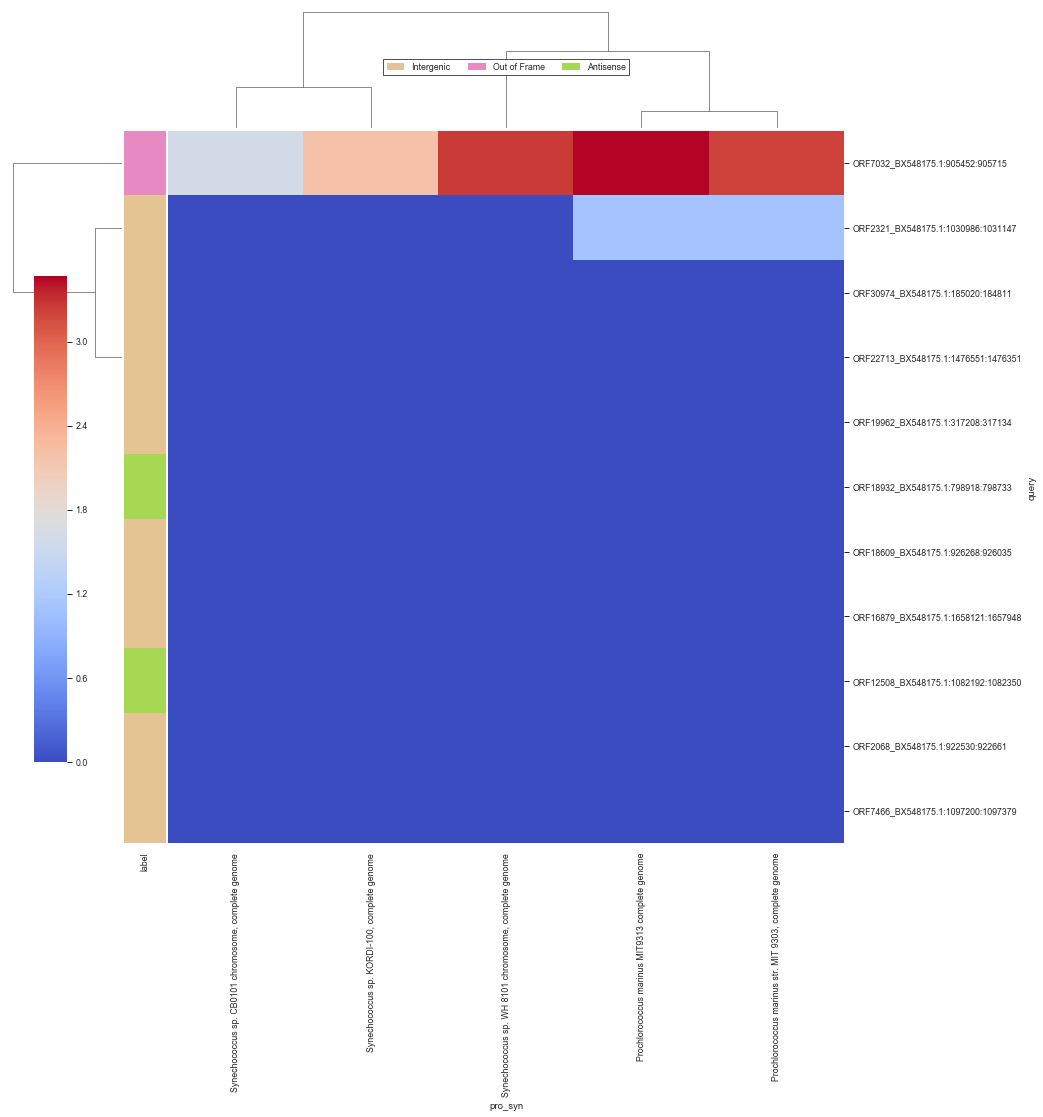

In [94]:
p = pivotdf.loc[found_sorf_df.loc[
    found_sorf_df.otype.isin(['Antisense', 'Out of Frame', 'Intergenic']), 'orfid']]
row_colors = row_col[p.index].map(col_pal)

g = sns.clustermap(data=p.loc[:, p.sum()>1], 
                   cmap='coolwarm', row_colors=row_col[p.index].map(col_pal), figsize=(15,15),
                  linewidths=0, #xticklabels=False, #yticklabels=False, #standard_scale=0
                  )



for label in row_col[p.index].unique():
    g.ax_col_dendrogram.bar(0, 0, color=col_pal[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=6)
g.cax.set_position([.15, .2, .03, .45])


In [ ]:
pivotdf.head()

In [ ]:
pivotdf.sum().sort_values().value_counts().sort_index()

In [ ]:
pivotdf.sum()>10

In [ ]:
pivotdf.droplevel(0,axis=1).index

In [ ]:
blastn_vs_pro_df.pro_syn_accession

In [99]:
np.log(10)

2.302585092994046

In [96]:
pivotdf.head()

pro_syn,"A.nidulans ferredoxin (petF1) gene, complete cds","A.nidulans petF gene encoding ferredoxin I, complete cds",Anacystis nidulans R2 (= Synechococcus PCC7942) ferredoxin gene,Cyanobacterium Synechococcus 6301 DNA for ATP synthase subunits,Prochlorococcus marinus MED4 complete genome,Prochlorococcus marinus MIT9313 complete genome,Prochlorococcus marinus genomic region for RNase P RNA subunit and for Ribonuclease III,Prochlorococcus marinus phycobiliprotein gene cluster,"Prochlorococcus marinus str. AS9601 clone A9601_07641 conserved hypothetical protein gene, complete cds","Prochlorococcus marinus str. AS9601 clone A9601_16291 conserved hypothetical protein gene, complete cds",...,"Uncultured Synechococcus sp. clone SOMLIT-ASTAN-05292012_envPBS_SC31 PBS region, partial sequence","Uncultured Synechococcus sp. clone SOMLIT-ASTAN-05292012_envPBS_SC5 PBS region, partial sequence","Uncultured marine type-A Synechococcus 4O4, partial genome fragment","Uncultured marine type-A Synechococcus 5B2, partial genome fragment",Uncultured marine type-A Synechococcus GOM 3M9 rbcL-containing genomic sequence,Uncultured marine type-A Synechococcus GOM 3O12 rbcL-containing genomic sequence,Uncultured marine type-A Synechococcus GOM 3O6 rbcL-containing genomic sequence,Uncultured marine type-A Synechococcus GOM 4N23 rbcL-containing genomic sequence,Uncultured marine type-A Synechococcus GOM 4P21 rbcL-containing genomic sequence,Uncultured marine type-A Synechococcus GOM 5D20 rbcL-containing genomic sequence
query,,,,,,,,,,,,,,,,,,,,,
ORF10855_BX548175.1:349523:349801,0,0,0,0,693.147E-03,693.147E-03,0,0,0,0,...,0,0,0.000E+00,0.000E+00,0.000E+00,0.000E+00,0.000E+00,0.000E+00,0.000E+00,0.000E+00
ORF10932_BX548175.1:381020:381295,0,0,0,0,0.000E+00,0.000E+00,0,0,0,0,...,0,0,0.000E+00,0.000E+00,0.000E+00,0.000E+00,0.000E+00,0.000E+00,0.000E+00,0.000E+00
ORF11015_BX548175.1:417272:417571,0,0,0,0,0.000E+00,0.000E+00,0,0,0,0,...,0,0,0.000E+00,0.000E+00,0.000E+00,0.000E+00,0.000E+00,0.000E+00,0.000E+00,0.000E+00
ORF11235_BX548175.1:514397:514681,0,0,0,0,0.000E+00,0.000E+00,0,0,0,0,...,0,0,0.000E+00,0.000E+00,0.000E+00,0.000E+00,0.000E+00,0.000E+00,0.000E+00,0.000E+00
ORF11349_BX548175.1:562598:562816,0,0,0,0,0.000E+00,0.000E+00,0,0,0,0,...,0,0,0.000E+00,0.000E+00,0.000E+00,0.000E+00,0.000E+00,0.000E+00,0.000E+00,0.000E+00
